# Symbolic Solution for Limit Continuous Poker

This notebook derives the Nash equilibrium of LCP using transformed coordinates:
- $r = L/(1+L)$ (minimum pot odds)
- $t = 1/(1+U)$ (pot fraction at max bet)

The solution provides closed-form expressions for all strategic components.

In [35]:
import sympy as sp
import numpy as np
from sympy import symbols, Function, Eq, solve, diff, integrate, factor, lambdify
from typing import Dict
from dataclasses import dataclass
import game_utils.ContinuousPokerVariants.ContinuousPokerUtils as poker_utils

## Variable Definitions

In [3]:
# Transformed parameters and bet size (s) and hand strength (x)
r, t, s, x = symbols('r t s x')

# Original parameters in terms of r, t
L_expr = r / (1 - r)
U_expr = (1 - t) / t

# Hand strength thresholds
x0, x1, x2, x3, x4, x5 = symbols('x0 x1 x2 x3 x4 x5')

# Strategy functions
c_func = Function('c')  # Calling threshold
v_func = Function('v')  # Value betting
b_func = Function('b')  # Bluffing

# Integration constant
b0 = symbols('b0')

## Step 1: Calling Threshold c(s)

From bettor indifference at marginal bluffing hand $x_2$:
$$c(s) - (1-c(s))s = x_2$$

In [4]:
def derive_calling_threshold() -> sp.Expr:
    bettor_indiff_eq = Eq(c_func(s) - (1 - c_func(s)) * s, x2)
    c_solution = solve(bettor_indiff_eq, c_func(s))[0]
    return c_solution

c_expr = derive_calling_threshold()
print("✓ Derived c(s):")
display(Eq(c_func(s), c_expr))

✓ Derived c(s):


Eq(c(s), (s + x2)/(s + 1))

## Step 2: Value Betting Function v(s)

From first-order optimality, the bettor with hand $v(s)$ must be indifferent about bet size.

In [5]:
def derive_value_function(c_expr: sp.Expr) -> sp.Expr:
    optimality_ode = Eq(-s * diff(c_expr, s) - c_expr + 2 * v_func(s) - 1, 0)
    v_solution = solve(optimality_ode, v_func(s))[0]
    return v_solution

v_expr = derive_value_function(c_expr)
print("✓ Derived v(s):")
display(Eq(v_func(s), v_expr))

✓ Derived v(s):


Eq(v(s), (2*s**2 + 4*s + x2 + 1)/(2*(s**2 + 2*s + 1)))

## Step 3: Bluffing Function b(s)

From caller indifference at threshold $c(s)$:
$$-b'(s)(1+s) = v'(s)s$$

In [6]:
def derive_bluffing_function(v_expr: sp.Expr) -> sp.Expr:
    caller_indiff_ode = Eq(diff(b_func(s), s) * (1 + s) + diff(v_expr, s) * s, 0)
    b_solution = sp.dsolve(caller_indiff_ode, b_func(s))
    b_solution_expr = b_solution.rhs.subs("C1", b0)
    return b_solution_expr

b_expr = derive_bluffing_function(v_expr)
print("✓ Derived b(s):")
display(Eq(b_func(s), b_expr))

✓ Derived b(s):


Eq(b(s), b0 - (3*s + 1)*(x2 - 1)/(6*(s**3 + 3*s**2 + 3*s + 1)))

## Step 4: Hand Strength Thresholds

Solve for $x_0, x_1, x_3, x_4, x_5$ using boundary conditions.

In [7]:
print("Solving for hand strength thresholds...")

c_at_L = c_expr.subs(s, L_expr)
v_at_L = v_expr.subs(s, L_expr)
v_at_U = v_expr.subs(s, U_expr)

equations = [
    Eq(x2 - x1 - r * (x4 - x3), 0),
    Eq(x0 - (1 - x5) * (1 - t), 0),
    Eq(x3 - (1 + c_at_L) / 2, 0),
    Eq(v_at_L, x4),
    Eq(v_at_U, x5),
]

threshold_solution = sp.linsolve(equations, (x0, x1, x3, x4, x5))
threshold_tuple = list(threshold_solution)[0]

thresholds = {
    var: expr
    for var, expr in zip([x0, x1, x3, x4, x5], threshold_tuple)
}

print("✓ Solved for x0, x1, x3, x4, x5 in terms of x2\n")
for name in ['x0', 'x1', 'x3', 'x4', 'x5']:
    sym = symbols(name)
    display(Eq(sym, thresholds[sym]))

Solving for hand strength thresholds...
✓ Solved for x0, x1, x3, x4, x5 in terms of x2



Eq(x0, t**3*x2/2 - t**3/2 - t**2*x2/2 + t**2/2)

Eq(x1, -r**3*x2/2 + r**3/2 + r**2*x2/2 - r**2/2 + x2)

Eq(x3, -r*x2/2 + r/2 + x2/2 + 1/2)

Eq(x4, r**2*x2/2 - r**2/2 - r*x2 + r + x2/2 + 1/2)

Eq(x5, t**2*x2/2 - t**2/2 + 1)

## Step 5: Solve for x2 and b0

Using boundary conditions: $b(U) = x_0$ and $b(L) = x_1$.

In [8]:
b_at_L = b_expr.subs(s, L_expr)
b_at_U = b_expr.subs(s, U_expr)

boundary_equations = [
    Eq(b_at_U, thresholds[x0]),
    Eq(b_at_L, thresholds[x1]),
]

b0_x2_solution = sp.linsolve(boundary_equations, (b0, x2))
b0_val, x2_val = list(b0_x2_solution)[0]

print("✓ Solved for x2 and b0:")
display(Eq(x2, x2_val))
display(Eq(b0, b0_val))

✓ Solved for x2 and b0:


Eq(x2, (r**3 + t**3 - 1)/(r**3 + t**3 - 7))

Eq(b0, t**3/(r**3 + t**3 - 7))

## Step 6: Simplify Complete Solution

In [23]:
print("Simplifying expressions...")
thresholds[x2] = x2_val
thresholds[b0] = b0_val

for key in [x0, x1, x3, x4, x5]:
    thresholds[key] = thresholds[key].subs(x2, x2_val).simplify()

c_expr_final = c_expr.subs(x2, x2_val).simplify()
v_expr_final = v_expr.subs(x2, x2_val).simplify()
b_expr_final = b_expr.subs(b0, b0_val).subs(x2, x2_val).simplify()
b_expr_final = ((sp.numer(b_expr_final) + (3*s+1)).factor() - (3*s+1))/ sp.denom(b_expr_final)

print("✓ Simplified all expressions")

Simplifying expressions...
✓ Simplified all expressions


## Step 7: Inverse Value Function

In [25]:
def derive_inverse_value_function(v_expr):
    v_inv_expr = -1 - sp.sqrt( (4*x-4) * (-2 + 2*x2) ) / (4*x-4)
    assert x == v_expr.subs(s, v_inv_expr).simplify()
    return v_inv_expr.subs(x2, x2_val).simplify()

v_inv_expr = derive_inverse_value_function(v_expr)

## Complete Solution

In [26]:
@dataclass
class LCPSolution:
    thresholds: Dict[sp.Symbol, sp.Expr]
    c_expr: sp.Expr
    v_expr: sp.Expr
    b_expr: sp.Expr

    def display(self):
        print("=" * 70)
        print("LIMIT CONTINUOUS POKER - Nash Equilibrium Solution")
        print("=" * 70)
        print()

        print("Hand Strength Thresholds:")
        print("-" * 70)
        for name in ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']:
            sym = symbols(name)
            expr = self.thresholds[sym]
            display(Eq(sym, expr))
        print()

        print("Strategy Functions:")
        print("-" * 70)
        display(Eq(c_func(s), self.c_expr))
        display(Eq(v_func(s), self.v_expr))
        display(Eq(b_func(s), self.b_expr))
        print()

    def to_latex(self) -> Dict[str, str]:
        latex_dict = {}
        for sym, expr in self.thresholds.items():
            latex_dict[str(sym)] = sp.latex(Eq(sym, expr))
        latex_dict['c(s)'] = sp.latex(Eq(c_func(s), self.c_expr))
        latex_dict['v(s)'] = sp.latex(Eq(v_func(s), self.v_expr))
        latex_dict['b(s)'] = sp.latex(Eq(b_func(s), self.b_expr))
        return latex_dict

solution = LCPSolution(
    thresholds=thresholds,
    c_expr=c_expr_final,
    v_expr=v_expr_final,
    b_expr=b_expr_final
)

solution.display()

LIMIT CONTINUOUS POKER - Nash Equilibrium Solution

Hand Strength Thresholds:
----------------------------------------------------------------------


Eq(x0, 3*t**2*(t - 1)/(r**3 + t**3 - 7))

Eq(x1, (-2*r**3 + 3*r**2 + t**3 - 1)/(r**3 + t**3 - 7))

Eq(x2, (r**3 + t**3 - 1)/(r**3 + t**3 - 7))

Eq(x3, (r**3 - 3*r + t**3 - 4)/(r**3 + t**3 - 7))

Eq(x4, (r**3 + 3*r**2 - 6*r + t**3 - 4)/(r**3 + t**3 - 7))

Eq(x5, (r**3 + t**3 + 3*t**2 - 7)/(r**3 + t**3 - 7))


Strategy Functions:
----------------------------------------------------------------------


Eq(c(s), (r**3 + s*(r**3 + t**3 - 7) + t**3 - 1)/((s + 1)*(r**3 + t**3 - 7)))

Eq(v(s), (r**3 + t**3 + (r**3 + t**3 - 7)*(2*s**2 + 4*s + 1) - 1)/(2*(r**3 + t**3 - 7)*(s**2 + 2*s + 1)))

Eq(b(s), (-3*s + t**3*(s + 1)**3 - 1)/((r**3 + t**3 - 7)*(s**3 + 3*s**2 + 3*s + 1)))

## Numerical Strategy Functions

In [27]:
def _convert_params(**kwargs):
    if 'L' in kwargs and 'U' in kwargs:
        L_val = kwargs['L']
        U_val = kwargs['U']
        r_val = L_val / (1 + L_val)
        t_val = 1 / (1 + U_val)
        return r_val, t_val
    elif 'r' in kwargs and 't' in kwargs:
        return kwargs['r'], kwargs['t']
    else:
        raise ValueError("Must provide either (L, U) or (r, t) parameters")

def call_threshold(s_val, **kwargs):
    r_val, t_val = _convert_params(**kwargs)
    c_numeric = lambdify(s, solution.c_expr.subs({r: r_val, t: t_val}))
    return float(c_numeric(s_val))

def bluff_threshold(**kwargs):
    r_val, t_val = _convert_params(**kwargs)
    x2_expr = solution.thresholds[x2].subs({r: r_val, t: t_val})
    return float(x2_expr)

def value_threshold(**kwargs):
    r_val, t_val = _convert_params(**kwargs)
    x3_expr = solution.thresholds[x3].subs({r: r_val, t: t_val})
    return float(x3_expr)

def bluff_size(x_val, **kwargs):
    r_val, t_val = _convert_params(**kwargs)
    L_val = r_val / (1 - r_val)
    U_val = (1 - t_val) / t_val

    x0_val = solution.thresholds[x0].subs({r: r_val, t: t_val})
    x1_val = solution.thresholds[x1].subs({r: r_val, t: t_val})
    x2_val = solution.thresholds[x2].subs({r: r_val, t: t_val})
    b0_val = solution.thresholds[b0].subs({r: r_val, t: t_val})

    if x_val < x0_val:
        return U_val
    elif x_val < x1_val:
        from scipy.optimize import brentq
        b_substituted = solution.b_expr.subs({
            r: r_val,
            t: t_val,
            x2: x2_val,
            b0: b0_val
        })
        b_numeric = lambdify(s, b_substituted)
        try:
            result = brentq(lambda s_test: b_numeric(s_test) - x_val, L_val, U_val)
            return result
        except:
            return None
    else:
        return L_val

def value_size(x_val, **kwargs):
    r_val, t_val = _convert_params(**kwargs)
    L_val = r_val / (1 - r_val)
    U_val = (1 - t_val) / t_val

    x4_val = solution.thresholds[x4].subs({r: r_val, t: t_val})
    x5_val = solution.thresholds[x5].subs({r: r_val, t: t_val})

    if x_val < x4_val:
        return L_val
    elif x_val < x5_val:
        vinv_numeric = lambdify(x, v_inv_expr.subs({r: r_val, t: t_val}))
        return float(vinv_numeric(x_val))
    else:
        return U_val

## Visualization

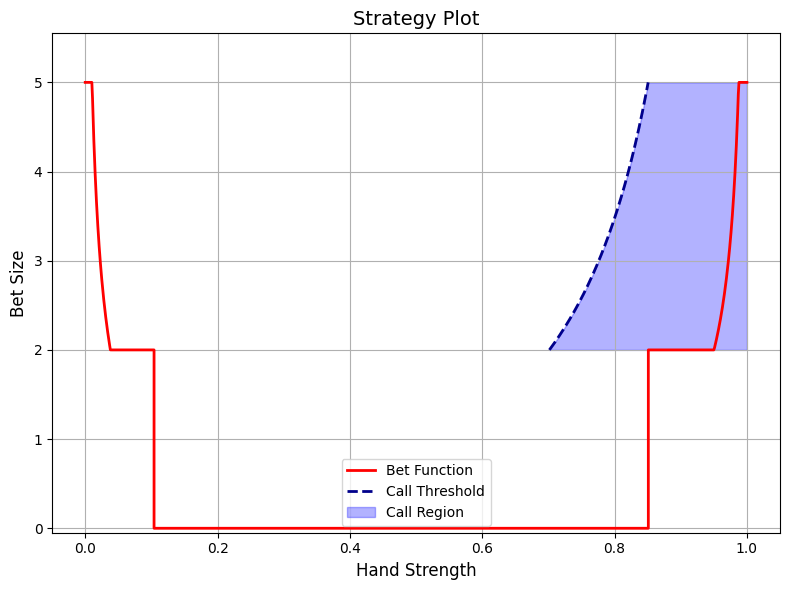

In [29]:
poker_utils.generate_strategy_plot(
    bluff_threshold,
    bluff_size,
    value_threshold,
    value_size,
    call_threshold,
    L=2, U=5
)

## LaTeX Output

In [ ]:
print("=" * 70)
print("LaTeX Format:")
print("=" * 70)
latex_output = solution.to_latex()
for key, latex_str in latex_output.items():
    print(latex_str)

LaTeX Format:
x_{0} = \frac{3 t^{2} \left(t - 1\right)}{r^{3} + t^{3} - 7}
x_{1} = \frac{- 2 r^{3} + 3 r^{2} + t^{3} - 1}{r^{3} + t^{3} - 7}
x_{3} = \frac{r^{3} - 3 r + t^{3} - 4}{r^{3} + t^{3} - 7}
x_{4} = \frac{r^{3} + 3 r^{2} - 6 r + t^{3} - 4}{r^{3} + t^{3} - 7}
x_{5} = \frac{r^{3} + t^{3} + 3 t^{2} - 7}{r^{3} + t^{3} - 7}
x_{2} = \frac{r^{3} + t^{3} - 1}{r^{3} + t^{3} - 7}
b_{0} = \frac{t^{3}}{r^{3} + t^{3} - 7}
c{\left(s \right)} = \frac{r^{3} + s \left(r^{3} + t^{3} - 7\right) + t^{3} - 1}{\left(s + 1\right) \left(r^{3} + t^{3} - 7\right)}
v{\left(s \right)} = \frac{r^{3} + t^{3} + \left(r^{3} + t^{3} - 7\right) \left(2 s^{2} + 4 s + 1\right) - 1}{2 \left(r^{3} + t^{3} - 7\right) \left(s^{2} + 2 s + 1\right)}
b{\left(s \right)} = \frac{- 3 s + t^{3} \left(s + 1\right)^{3} - 1}{\left(r^{3} + t^{3} - 7\right) \left(s^{3} + 3 s^{2} + 3 s + 1\right)}


## Game Value Computation

In [59]:
def compute_game_value(solution: LCPSolution) -> sp.Expr:
    bluff_payoff = solution.thresholds[x2] - sp.Rational(1, 2)
    check_payoff = x - sp.Rational(1, 2)
    min_bet_payoff = (x * (2*L_expr + 1) - L_expr * (solution.c_expr.subs(s, L_expr) + 1) - sp.Rational(1, 2)).simplify()
    max_bet_payoff = (x * (2*U_expr + 1) - U_expr * (solution.c_expr.subs(s, U_expr) + 1) - sp.Rational(1, 2)).simplify()
    
    intermediate_bet_payoff = (x * (2*v_inv_expr + 1) - v_inv_expr * (solution.c_expr.subs(s, v_inv_expr) + 1) - sp.Rational(1, 2)).simplify()
    q = sp.Symbol('q')
    q_expr = (x-1)/(r**3+t**3-7)
    intermediate_bet_payoff = intermediate_bet_payoff.subs(q_expr, q).collect(q).collect(x).subs(q, q_expr)

    bluff_integral = integrate(
        bluff_payoff,
        (x, 0, thresholds[x2])
    ).simplify()

    check_integral = integrate(
        check_payoff,
        (x, thresholds[x2], thresholds[x3])
    ).simplify()
    
    min_bet_integral = integrate(
        min_bet_payoff,
        (x, thresholds[x3], thresholds[x4])
    ).simplify()

    max_bet_integral = integrate(
        max_bet_payoff,
        (x, thresholds[x5], 1)
    ).simplify()

    intermediate_bet_integral = integrate(
        intermediate_bet_payoff,
        (x, thresholds[x4], thresholds[x5])
    ).simplify()
    
    game_value = bluff_integral + check_integral + min_bet_integral + max_bet_integral + intermediate_bet_integral
    return game_value.simplify()

game_value = compute_game_value(solution)
display(game_value)

(3*(r*(r**4 - 4*r**3 - 6*r**2 + r*t**3 + 8*r - t**3 + 1) + t**2*(-r**3 - t**3 + 3*t**2 - 18*t + 19))*(r**3 + t**3 - 7)**2 + (r**6 + 2*r**3*t**3 - 14*r**3 + t**6 - 14*t**3 + 49)*(3*r**3*(r**3 + t**3 + 3*t**2 - 7) + 3*r**3*(-r**3 - 3*r**2 + 6*r - t**3 + 4) + 99*r**2 - 198*r + 3*t**3*(r**3 + t**3 + 3*t**2 - 7) + 3*t**3*(-r**3 - 3*r**2 + 6*r - t**3 + 4) - 99*t**2 - 48*(t**2/(r**3 + t**3 - 7)**2)**(3/2)*(r**3 + t**3 - 7)**3 + 48*((r**2 - 2*r + 1)/(r**3 + t**3 - 7)**2)**(3/2)*(r**3 + t**3 - 7)**3 + 3*(r + 1)*(r**3 + t**3 - 7) - (r**3 + t**3 - 1)**2 + (r**3 + t**3 - 1)*(r**3 + t**3 + 5) + (r**3 - 3*r + t**3 - 4)**2 - (r**3 + t**3 + 3*t**2 - 7)**2 + (r**3 + 3*r**2 - 6*r + t**3 - 4)**2 + 99))/(2*(r**3 + t**3 - 7)**2*(r**6 + 2*r**3*t**3 - 14*r**3 + t**6 - 14*t**3 + 49))

## Simplification of Game Value to Closed Form

The game value expression above simplifies to:
$$V(r,t) = \frac{r^3 + t^3 - 1}{2(r^3 + t^3 - 7)}$$

**Proof sketch:** 

1. **Substitution:** Let $u = r^3 + t^3 - 7$ to simplify notation.

2. **Common denominator:** Note that $(r^3 + t^3 - 7)^2 = r^6 + 2r^3t^3 + t^6 - 14r^3 - 14t^3 + 49$, so all terms can be written with denominator $2u^3$.

3. **Expand and collect:** Expand all products and collect terms over the common denominator $2u^3$. Use $t^3 - (r-1)^3 = t^3 - r^3 + 3r^2 - 3r + 1$ for the fourth term.

4. **Cancellation:** After expanding and collecting like powers of $u$:
   - All $u^3$ terms cancel
   - Most $u^2$ terms cancel, leaving only $u^2(u + 6) = u^3 + 6u^2$ in the numerator
   - Lower order terms cancel

5. **Final simplification:**
   $$\frac{u^3 + 6u^2}{2u^3} = \frac{u^2(u + 6)}{2u^3} = \frac{u + 6}{2u} = \frac{(r^3 + t^3 - 7) + 6}{2(r^3 + t^3 - 7)} = \frac{r^3 + t^3 - 1}{2(r^3 + t^3 - 7)}$$

In [ ]:
# sanity check - do the expressions agree on random inputs?
def numerical_eq(expr1, expr2, tolerance=1e-9, iters=1000):
    for i in range(iters):
        r_val = np.random.rand()
        t_val = np.random.rand()
        vals = {r: r_val, t: t_val}
        if r_val + t_val > 1:
            continue
        if np.abs(expr1.subs(vals) - expr2.subs(vals)) > tolerance:
            print(vals)
            print(expr1.subs(vals), expr2.subs(vals))
            return False
    return True

known_form = (1-r**3-t**3)/(14-2*r**3-2*t**3)
numerical_eq(known_form, game_value)

True